In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os, sys
from tqdm import tqdm, trange

sys.path.append("../")
from models import utils
from models import neural_fields, bfield

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Set up plotting parameters
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook
plt.show()
from models.plot_params import params

defaulparams = plt.rcParams.copy()
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [25]:
# Readind the data:
import astropy.io.fits as fits

datadir = 'plage_sst/'
img = np.ascontiguousarray(fits.open(datadir+'CRISP_5173_plage_dat.fits', 'readonly')[0].data, dtype='float32')
xl = np.ascontiguousarray(fits.open(datadir+'CRISP_5173_plage_wav.fits', 'readonly')[0].data, dtype='float32')
ny, nx, nStokes, nWav = img.shape



In [26]:
# Implicit parameters:
wBQU = 8.0
wBlos = 40.0
niter_ = 200

# Batch size:
batchcoord = 20000

# WFA model:
wfamodel = bfield.WFA_model3D(img,xl,mask=[5,6,7],spectral_line=5173)

coordinates, _ = utils.to_coordinates_and_features(img[:,:,0,0][None,:,:])
coordinates.requires_grad = True

Data: torch.Size([200, 178, 4, 13]) should be in the format [(nt) ny nx ns nw]


## Neural field for $B_{\parallel}$

Number of batches per epoch: 2


100%|██████████| 200/200 [00:41<00:00,  4.87it/s, loss = 1.39e-04]


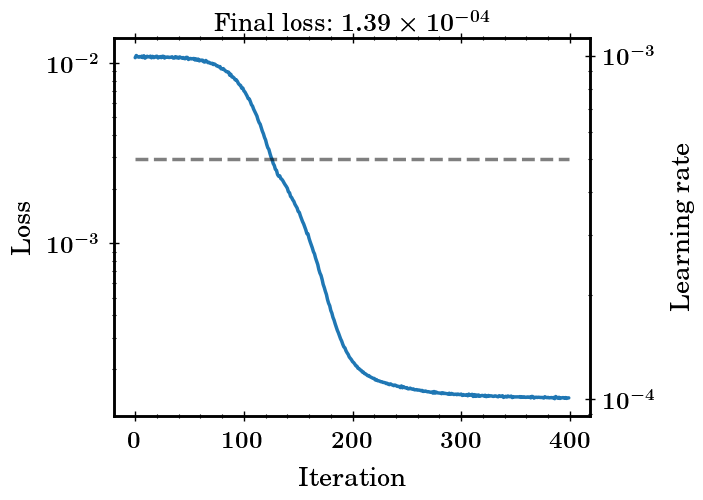

In [27]:
# Define the neural field model:
nfmodel_blos = neural_fields.mlp(dim_in=2,dim_out=1,num_resnet_blocks=2,dim_hidden=64,fourier_features=True,m_freqs=512,sigma=wBlos)

# Train the model:
output_dict_blos = neural_fields.Trainer_gpu_full(nfmodel_blos, wfamodel, coordinates, niter=niter_, lrinit=5e-4, batchcoord=batchcoord, trainBV=True)
_ = neural_fields.plot_loss(output_dict_blos)

In [28]:
# Retrieve the results:
blos = nfmodel_blos(coordinates).detach().numpy().reshape(img.shape[0],img.shape[1],1)*wfamodel.Vnorm

## Neural field for $B_{\perp}$ and $\Phi_B$

Number of batches per epoch: 2


100%|██████████| 200/200 [00:41<00:00,  4.87it/s, loss = 2.61e-04]


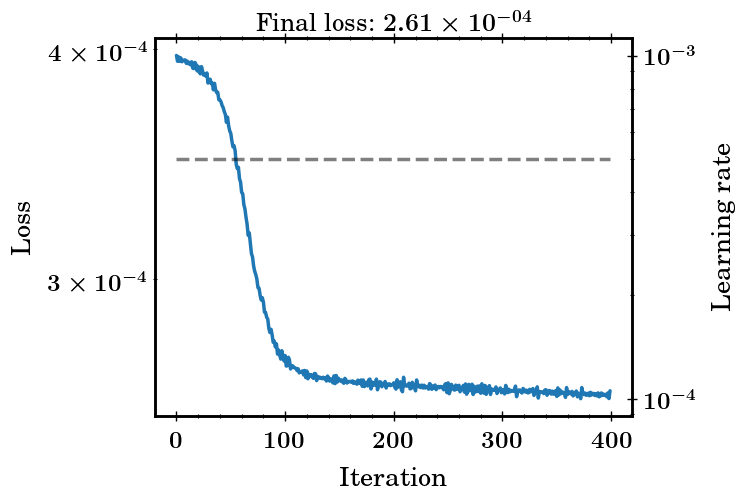

In [29]:
# Define the neural field model:
nfmodel_bqu = neural_fields.mlp(dim_in=2,dim_out=2,num_resnet_blocks=2,dim_hidden=64,fourier_features=True,m_freqs=512,sigma=wBQU)

# Train the model:
output_dict_bqu = neural_fields.Trainer_gpu_full(nfmodel_bqu, wfamodel, coordinates, niter=niter_, lrinit=5e-4, batchcoord=batchcoord, trainBV=False, patience=100)
_ = neural_fields.plot_loss(output_dict_bqu)

In [30]:
# Retrieve the results:
BQU = nfmodel_bqu(coordinates).detach().numpy().reshape(img.shape[0],img.shape[1],2)*wfamodel.QUnorm

# Plotting the results

In [31]:
Blos, Bhor, Bazi = bfield.bqu2polar(blos,BQU[:,:,0],BQU[:,:,1])


Text(0.5, 0.98, 'Neural field WFA inversion')

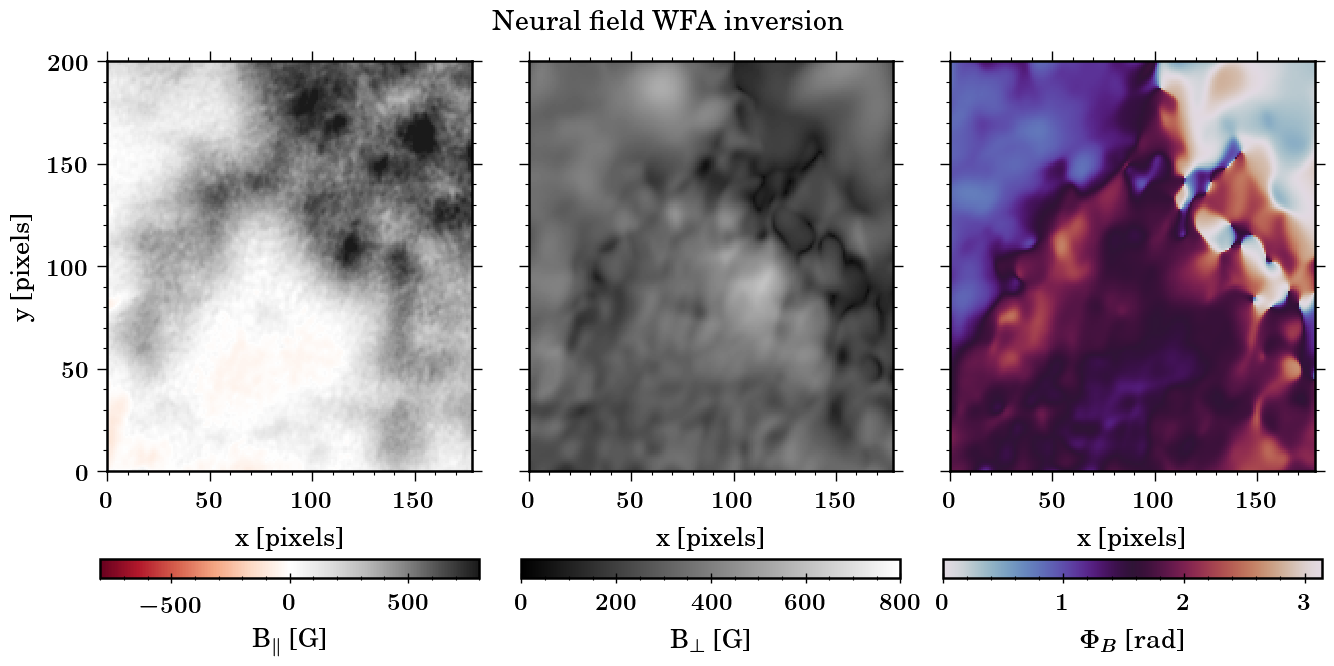

In [39]:
# Plots
plt.close("all");
extent = np.float64((0,nx,0,ny))
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(9*1.5,4.5*1.5))
im0 = ax[0].imshow(Blos, vmax=800, vmin=-800, cmap='RdGy',      interpolation='nearest', extent=extent)
im1 = ax[1].imshow(Bhor, vmin=0, vmax=800,   cmap='gray', interpolation='nearest', extent=extent)
im2 = ax[2].imshow(Bazi, vmax=np.pi, vmin=0,    cmap='twilight',      interpolation='nearest', extent=extent)

names = [r'B$_\parallel$', r'B$_\bot$', r'$\Phi_B$']
f.colorbar(im0, ax=ax[0], orientation='horizontal', label=names[0]+' [G]')
f.colorbar(im1, ax=ax[1], orientation='horizontal', label=names[1]+' [G]')
f.colorbar(im2, ax=ax[2], orientation='horizontal', label=names[2]+' [rad]')

for ii in range(1,3):
    ax[ii].set_yticklabels([])
for ii in range(3):
    ax[ii].set_xlabel('x [pixels]')
    ax[ii].minorticks_on()
    ax[ii].locator_params(axis='x', nbins=5)
    ax[ii].locator_params(axis='y', nbins=5)
ax[0].set_ylabel('y [pixels]')
f.set_tight_layout(True)

for axi in ax: # Include ticks inside in the plots:
    axi.tick_params(which='both', direction='out', top=True, right=True)
for cbar in f.get_axes():
    cbar.minorticks_on() # Minorticks in the colorbar:

plt.suptitle('Neural field WFA inversion', fontsize=20)

Text(0.5, 0.98, 'Pixel-wise WFA inversion')

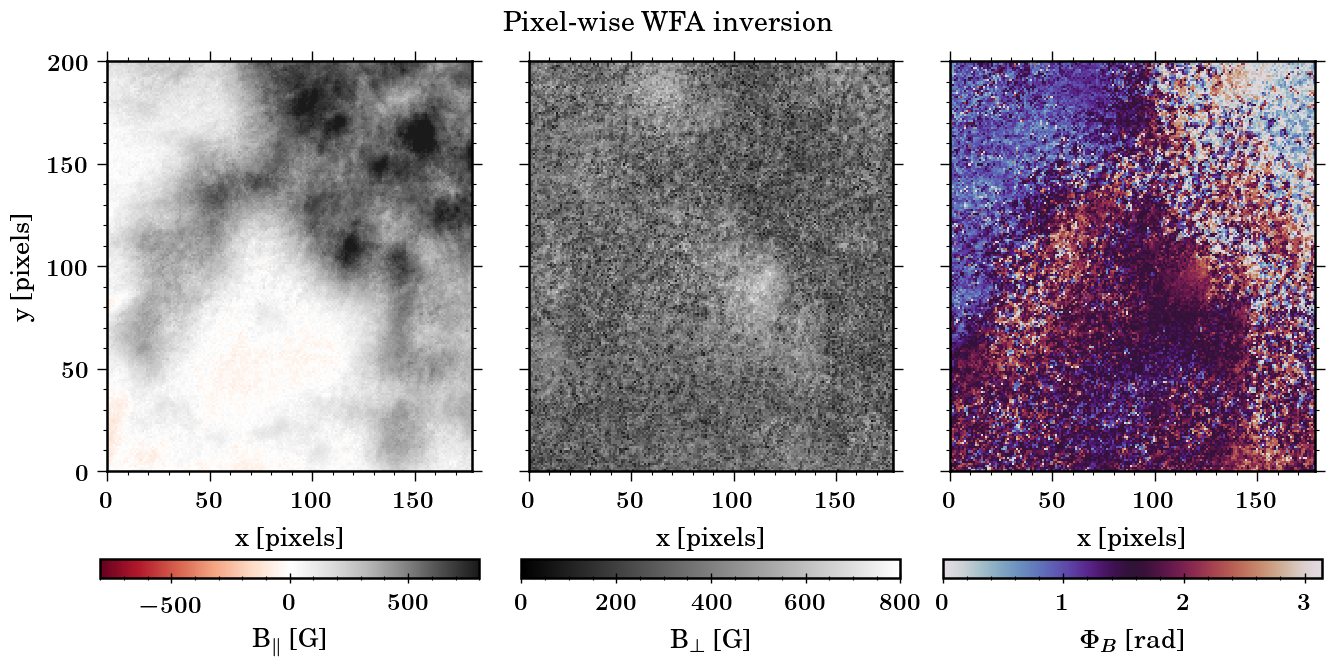

In [40]:
# Same for the pixel-wise WFA model:
Blos_, Bhor_, Bazi_ = wfamodel.initial_guess(inner=False, split=True)

# Plots
plt.close("all");
extent = np.float64((0,nx,0,ny))
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(9*1.5,4.5*1.5))
im0 = ax[0].imshow(Blos_.reshape(img.shape[0],img.shape[1]), vmax=800, vmin=-800, cmap='RdGy',      interpolation='nearest', extent=extent)
im1 = ax[1].imshow(Bhor_.reshape(img.shape[0],img.shape[1]), vmin=0, vmax=800,   cmap='gray', interpolation='nearest', extent=extent)
im2 = ax[2].imshow(Bazi_.reshape(img.shape[0],img.shape[1]), vmax=np.pi, vmin=0,    cmap='twilight',      interpolation='nearest', extent=extent)

names = [r'B$_\parallel$', r'B$_\bot$', r'$\Phi_B$']
f.colorbar(im0, ax=ax[0], orientation='horizontal', label=names[0]+' [G]')
f.colorbar(im1, ax=ax[1], orientation='horizontal', label=names[1]+' [G]')
f.colorbar(im2, ax=ax[2], orientation='horizontal', label=names[2]+' [rad]')

for ii in range(1,3):
    ax[ii].set_yticklabels([])
for ii in range(3):
    ax[ii].set_xlabel('x [pixels]')
    ax[ii].minorticks_on()
    ax[ii].locator_params(axis='x', nbins=5)
    ax[ii].locator_params(axis='y', nbins=5)
ax[0].set_ylabel('y [pixels]')
f.set_tight_layout(True)

for axi in ax: # Include ticks inside in the plots:
    axi.tick_params(which='both', direction='out', top=True, right=True)
for cbar in f.get_axes():
    cbar.minorticks_on() # Minorticks in the colorbar:

plt.suptitle('Pixel-wise WFA inversion', fontsize=20)